In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_score 
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import TruncatedSVD
import vsm
from lib_classification import *
from pathlib import Path, PureWindowsPath
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning) #pour ignorer les warnings de type "deprecated"
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.min_rows', 5)
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_colwidth', None) #afficher texte entier dans les colonnes du dataframe
np.set_printoptions(suppress=True) # notation scientifique desactivee

In [43]:
def get_all_reweighted_matrices(X, y, indices, test_size, random_state, n_components_svd):
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=test_size, random_state=random_state)

    count_vectorizer = CountVectorizer()
    X_train_count = count_vectorizer.fit_transform(X_train)
    X_train_normalized = normalize(X_train_count, norm='l2', axis=1) #normalisation par ligne
    tfidf_vectorizer = TfidfVectorizer()
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    svd = TruncatedSVD(n_components=n_components_svd, n_iter=7, random_state=42)
    X_train_tfidf_svd = svd.fit_transform(X_train_tfidf)
    hashing_vectorizer = HashingVectorizer()
    
    X_train_hashing = hashing_vectorizer.fit_transform(X_train)
    X_train_observed_expected = vsm.observed_over_expected(X_train_count)
    X_train_pmi = vsm.pmi(X_train_count)
    svd = TruncatedSVD(n_components=n_components_svd, n_iter=7, random_state=42)
    X_train_pmi_svd = svd.fit_transform(X_train_pmi)

    X_test_count = count_vectorizer.transform(X_test)
    X_test_normalized = normalize(X_test_count, norm='l2', axis=1) #normalisation par ligne
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    X_test_hashing = hashing_vectorizer.transform(X_test)
    X_test_tfidf_svd = svd.transform(X_test_tfidf)
    X_test_observed_expected = vsm.observed_over_expected(X_test_count)
    X_test_pmi = vsm.pmi(X_test_count)
    X_test_pmi_svd = svd.transform(X_test_pmi) 

    transformations_names = ["count", "normalized", "tfidf", "hashing", "observed_expected", "pmi",
                                "pmi + lsa", "tfidf + lsa"]
    matrices_train = [X_train_count, X_train_normalized, X_train_tfidf, X_train_hashing, 
                            X_train_observed_expected, X_train_pmi, X_train_pmi_svd, X_train_tfidf_svd]
    matrices_test = [X_test_count, X_test_normalized, X_test_tfidf, X_test_hashing, 
                        X_test_observed_expected, X_test_pmi, X_test_pmi_svd, X_test_tfidf_svd]
                        
    return(transformations_names, matrices_train, matrices_test)

In [3]:
current_folder = PureWindowsPath(globals()['_dh'][0]).as_posix()
path_root = "/".join(current_folder.split("/")[:-2]) #remonter au dossier root du projet
os.chdir(path_root)
path = PureWindowsPath(os.getcwd() + "/data/input/data_philosophy_baptism.parquet")
# path = PureWindowsPath(os.getcwd() + "/data/input/data_middle_age_epistemology.parquet")
path = path.as_posix() #convertir en path linux (convertir les \\ en /)
corpus = pd.read_parquet(path) #engine="fastparquet"
corpus = get_balanced_binary_dataset(corpus, class_col_name="category")

print(corpus["category_bin"].value_counts())
print("presence de doublons ?")
print(corpus.id.duplicated().any())
print(corpus.index.duplicated().any())
corpus

0    1833
1    1833
Name: category_bin, dtype: int64
presence de doublons ?
False
False


,id,message,message_preprocessed,category,length,category_bin
0,0,"1. C’est tout simplement faux et c’est incomplet. Premièrement parce que [Irénée avant le IIIème siècle parle du pédobaptême](https://parlafoi.fr/2018/08/20/le-pedobapteme-lhistoire-de-leglise/). Deuxièmement parce que les pères, avant de parler du pédobaptême, comme Justin Martyr, établissent un parallèle entre baptême et circoncision et témoignent donc d’un raisonnement qui mène au pédobaptême. Et, troisièmement, parce que l’archéologie nous donne des preuves positives d’une pratique pédobaptiste au IIème siècle (Cf. J. Jeremias, _Infant Baptism in the First Four Centuries_ ).",tout simplement faux incomplet premièrement parce irénée avant iiième siècle parle pédobaptêmehttpsparlafoifrle-pedobapteme-lhistoire-de-leglise deuxièmement parce père avant parler pédobaptême comme justin martyr établissent parallèle entre baptême circoncision témoignent donc raisonnement mène pédobaptême troisièmement parce archéologie donne preuve positives pratique pédobaptiste iième siècle cf jeremias infant baptism in the first four centurie,baptism,587,0
1,1,"» Pour les anabaptistes en question, ces trois sujets avaient tous un lien avec la coercition en matière de foi. Aujourd’hui les débats sur le baptême, dans un contexte laïque, n’ont pas du tout la même résonance qu’au XVIe siècle. Aux yeux des anabaptistes, le baptême des enfants hérité de la période médiévale imposait la foi à des personnes qui ne l’avaient pas forcément choisi. Comment réformer une Église composée de personnes qui se croyaient chrétiennes en vertu de leur baptême et à qui l’on ne pouvait pas demander un véritable changement de vie, appelé conversion, sanctification ou discipulat dans le Nouveau Testament ? De plus, permettre le choix d’adhésion à la communauté ecclésiale sapait le fondement même de la théologie réformée selon laquelle la réforme de l’Église et de la cité allait de pair. Aux yeux de Zwingli, Bucer ou Calvin, on ne pouvait réformer une ville dont tous les habitants n’étaient pas membres de l’Église. Les enjeux politiques de ce débat étaient rarement visibles dans les écrits réformés, mais toujours sous-jacents dans les débats du XVIe siècle. » cf <http://flte.fr/wp- content/uploads/2015/08/ThEv2009-3-Calvin_et_anabaptistes.pdf>",» anabaptiste question trois sujet tous lien coercition matière foi hui débat baptême contexte laïque tout résonance xvie siècle yeux anabaptiste baptême enfant hérité période médiévale imposait foi personne forcément choisi comment réformer église composée personne croyaient chrétien vertu baptême pouvait demander véritable changement vie appelé conversion sanctification discipulat nouveau testament plus permettre choix adhésion communauté ecclésiale sapait fondement théologie réformée selon laquelle réforme église cité allait pair yeux zwingli bucer calvin pouvait réformer ville dont tous habitant membre église enjeu politique débat rarement visible écrit réformé toujours sous-jacents débat xvie siècle » cf httpfltefrwp- contentuploadsthev -- calvinetanabaptistespdf,baptism,1182,0
...,...,...,...,...,...,...
3664,3664,## Article 2 : Un homme peut-il avoir plus de béatitude qu’un autre ?,article homme peut-il avoir plus béatitude autre,philosophy,69,1
3665,3665,"L’Orthodoxie tardive a vu l’effilochage d’une grande partie du bon travail accompli par les théologiens réformés. Pourquoi cela ? En partie parce que la méthode scolastique, dont nous parlerons plus en détail plus loin, a été laissée de côté, mais aussi un certain nombre de points de vue philosophiques (cartésianisme, pensée leibnizienne, Wolffianisme et philosophie des Lumières) se sont liés ensemble à la pensée réformée. Les académies ont également vu un changement dans leur approche de la théologie. Les Lumières amenèrent avec elles des courants théologiques et philosophiques changeants, et les bastions de l’orthodoxie réformée devinrent rapidement des bastions de l’hérésie.",lorthodoxie tardive a vu e

In [4]:
X = corpus["message_preprocessed"]
# y = corpus["category"]
y = corpus["category_bin"]
indices = corpus["id"]
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.33, random_state=42)
# X_train = X_train.iloc[0:500]

In [5]:
test_size = 0.33
random_state = 42
n_components_svd = 2000
transformations_names, matrices_train, matrices_test = get_all_reweighted_matrices(X, y, indices, test_size, random_state, n_components_svd)
print(transformations_names)

c:\Users\eupho\anaconda3\lib\site-packages\scipy\sparse\base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


['count', 'normalized', 'tfidf', 'hashing', 'observed_expected', 'pmi', 'tfidf + lsa']


In [8]:
count_vectorizer = CountVectorizer()
X_train_count = count_vectorizer.fit_transform(X_train)

X_train_normalized = normalize(X_train_count, norm='l2', axis=1) #normalisation par ligne

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

hashing_vectorizer = HashingVectorizer()
X_train_hashing = hashing_vectorizer.fit_transform(X_train)

X_train_observed_expected = vsm.observed_over_expected(X_train_count).round(2)
# X_train_observed_expected = np.ravel(X_train_observed_expected)
# X_train_observed_expected = np.delete(X_train_observed_expected, np.where(X_train_observed_expected == 0))

X_train_pmi = vsm.pmi(X_train_count)

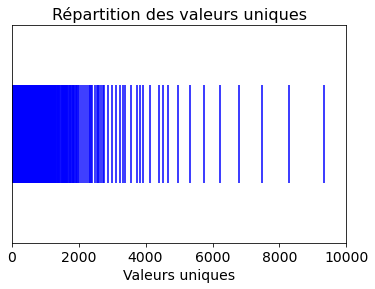

In [9]:
# Graphique avec barres en 1D des valeurs uniques (pour voir comment elles sont reparties, que a droite ?, que a gauche ?, etc.)
# sb.scatterplot(x=X_tfidf_unique, y=np.zeros_like(X_tfidf_unique), sizes=(10000,10000))
path = PureWindowsPath(os.getcwd() + "\\data\\output\\observed_expected_matrix_unique_distribution.png")
path = path.as_posix()

plt.figure()
plt.hlines(0,0,1)  # Draw a horizontal line
plt.eventplot(np.unique(X_train_observed_expected), orientation='horizontal', colors='b')
plt.xlabel("Valeurs uniques", size=14)
plt.title("Répartition des valeurs uniques", size=16)
plt.xticks(fontsize=14)
ax = plt.gca()
ax.get_yaxis().set_visible(False)
plt.rcParams["figure.figsize"] = (9, 4)
plt.xlim(0, 10000)
plt.savefig(path)
plt.show()

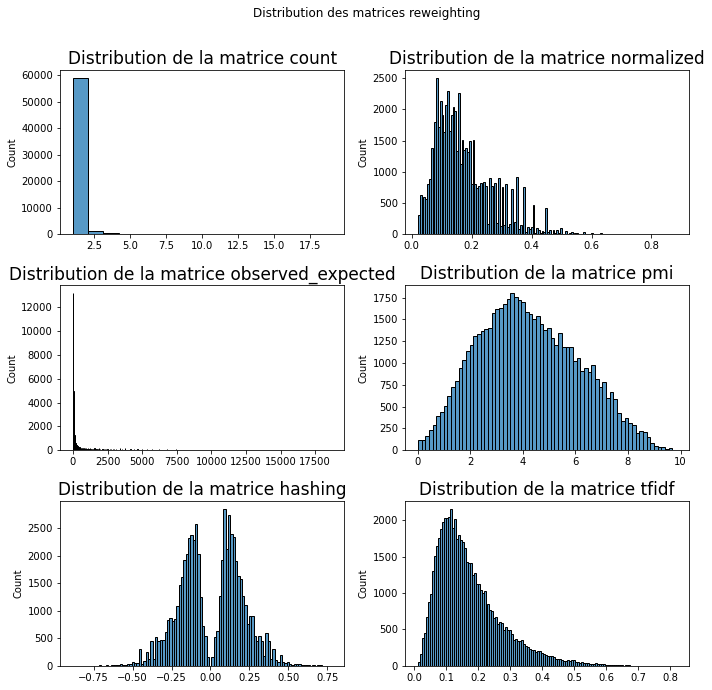

In [10]:
# Plot de toutes les distributions de matrices cote a cote
# Count, normalisation L2, expected observed, pmi, hashing, tfidf = 5 graphiques
path = PureWindowsPath(os.getcwd() + "\\data\\output\\count_matrix_reweighting_distribution.png")
path = path.as_posix()

fig, axes = plt.subplots(3, 2, figsize = (10, 10)) # Create a figure for 2 subplots (1 row, 2 columns)
fig.suptitle('Distribution des matrices reweighting')
fig.tight_layout(pad=3.0) #espace entre les graphiques

sb.histplot(X_train_count.data, edgecolor="black", linewidth=1, ax=axes[0,0])
axes[0,0].set_title("Distribution de la matrice count", size=17)

sb.histplot(X_train_normalized.data, edgecolor="black", linewidth=1, ax=axes[0,1])
axes[0,1].set_title("Distribution de la matrice normalized", size=17)

sb.histplot(np.ravel(X_train_observed_expected[X_train_observed_expected != 0]), edgecolor="black", linewidth=1, ax=axes[1,0])
axes[1,0].set_title("Distribution de la matrice observed_expected", size=17)

sb.histplot(np.ravel(X_train_pmi[X_train_pmi != 0]), edgecolor="black", linewidth=1, ax=axes[1,1])
axes[1,1].set_title("Distribution de la matrice pmi", size=17)

sb.histplot(X_train_hashing.data, edgecolor="black", linewidth=1, ax=axes[2,0])
axes[2,0].set_title("Distribution de la matrice hashing", size=17)

sb.histplot(X_train_tfidf.data, edgecolor="black", linewidth=1, ax=axes[2,1])
axes[2,1].set_title("Distribution de la matrice tfidf", size=17)

plt.savefig(path)

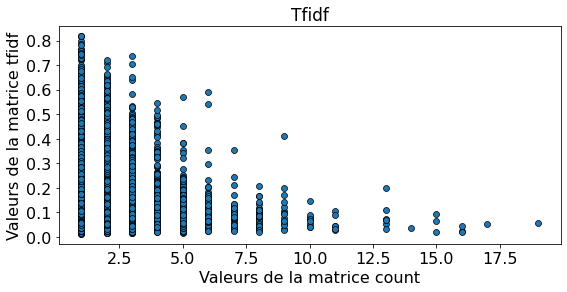

In [11]:
# Distribution matrice matrice
# Distribution des valeurs de la matrice tfidf
path = PureWindowsPath(os.getcwd() + "\\data\\output\\tfidf_vs_count_distribution.png")
path = path.as_posix()

sb.scatterplot(x=X_train_count.data, y=X_train_tfidf.data, edgecolor="black", linewidth=0.7)
plt.xlabel("Valeurs de la matrice count", size=16)
plt.ylabel("Valeurs de la matrice tfidf", size=16)
plt.title("Tfidf", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
# plt.xlim(0, 0.6)
plt.savefig(path)
plt.show()

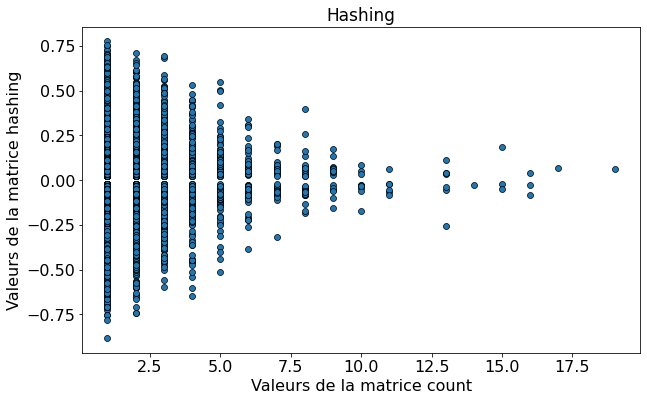

In [12]:
# Distribution matrice matrice
# Distribution des valeurs de la matrice hashing
path = PureWindowsPath(os.getcwd() + "\\data\\output\\hashing_vs_count_distribution.png")
path = path.as_posix()

sb.scatterplot(x=X_train_count.data, y=X_train_hashing.data, edgecolor="black", linewidth=0.7)
plt.xlabel("Valeurs de la matrice count", size=16)
plt.ylabel("Valeurs de la matrice hashing", size=16)
plt.title("Hashing", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
# plt.xlim(0, 0.6)
plt.savefig(path)
plt.show()

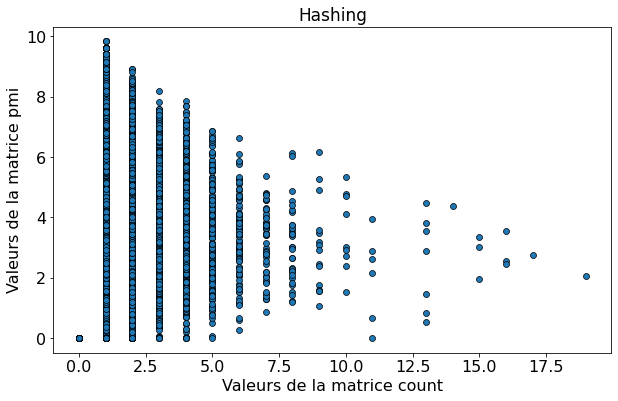

In [13]:
# Distribution matrice matrice
# Distribution des valeurs de la matrice pmi
path = PureWindowsPath(os.getcwd() + "\\data\\output\\hashing_vs_count_distribution.png")
path = path.as_posix()

sb.scatterplot(x=np.ravel(X_train_count.toarray()), y=np.ravel(X_train_pmi), edgecolor="black", linewidth=0.7)
plt.xlabel("Valeurs de la matrice count", size=16)
plt.ylabel("Valeurs de la matrice pmi", size=16)
plt.title("Hashing", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
# plt.xlim(0, 0.6)
plt.savefig(path)
plt.show()

Tests de performances sur plusieurs transformations de matrices (reweighting)

In [36]:
X_train_tfidf.shape

(2456, 9694)

In [39]:
# Reduction de dimension truncated svd/lsa apres tfidf 
svd = TruncatedSVD(n_components=2000, n_iter=7, random_state=42)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_train_tfidf_svd = svd.fit_transform(X_train_tfidf)
# print(X_train_tfidf_svd)
plt.rcParams["figure.figsize"] = (10, 6)
# sb.histplot(np.ravel(X_train_tfidf_svd[X_train_tfidf_svd != 0]), edgecolor="black", linewidth=1)
# plt.xlim(-0.2, 0.2)
svd.explained_variance_ratio_.sum()

0.9819463303212571

c:\Users\eupho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\eupho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


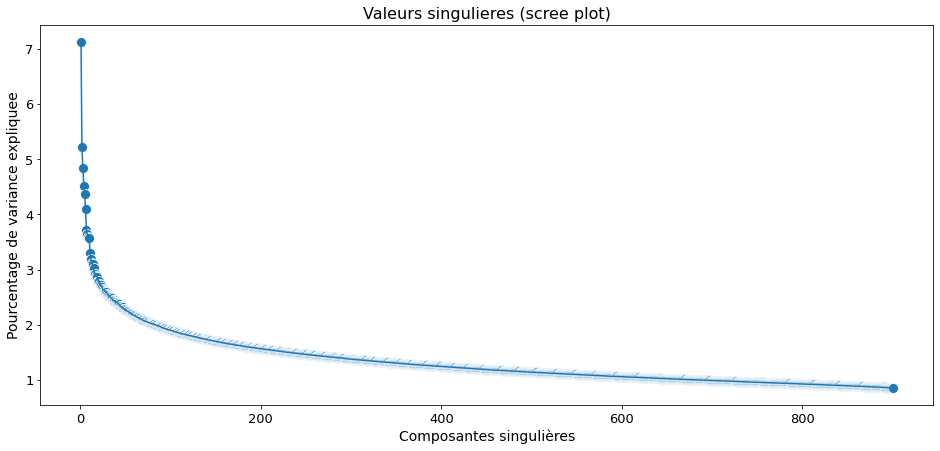

In [94]:
# Scree plot (graphe d'eboulis) = plot des valeurs singulieres (dans l'ordre decroissant)
x = np.arange(len(svd.components_)) + 1
sb.lineplot(x, svd.singular_values_)
sb.scatterplot(x, svd.singular_values_, s=100)
plt.xlabel("Composantes singulières", size=14)
plt.ylabel("Pourcentage de variance expliquee", size=14)
plt.title("Valeurs singulieres (scree plot)", size=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.xticks(np.arange(min(x), max(x)+1, 2.0))
plt.rcParams["figure.figsize"] = (16, 7)

pourcentage variance expliquee par toutes les variables svd = 77.59512315804677
pourcentage variance expliquee par les 40 premieres variables svd = 16.223060628043378


c:\Users\eupho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\eupho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


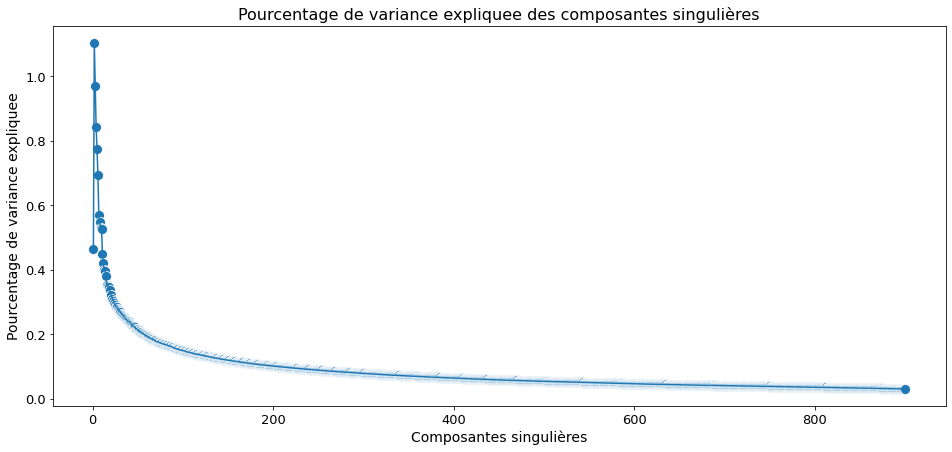

In [95]:
# Pourcentage de variance expliquee des composantes singulières
n_dim_chosen = 200
# print("pourcentage variance expliquee =", svd.explained_variance_ratio_ * 100)
print("pourcentage variance expliquee par toutes les variables svd =", svd.explained_variance_ratio_.sum() * 100)
print("pourcentage variance expliquee par les 40 premieres variables svd =", svd.explained_variance_ratio_[:40].sum() * 100)
# sb.barplot(data=df_explained_var, x=0, y=1)
x = np.arange(len(svd.components_)) + 1
sb.lineplot(x, svd.explained_variance_ratio_ * 100)
sb.scatterplot(x, svd.explained_variance_ratio_ * 100, s=100)
plt.xlabel("Composantes singulières", size=14)
plt.ylabel("Pourcentage de variance expliquee", size=14)
plt.title("Pourcentage de variance expliquee des composantes singulières", size=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.xticks(np.arange(min(x), max(x)+1, 2.0))
plt.rcParams["figure.figsize"] = (16, 7)

c:\Users\eupho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\eupho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


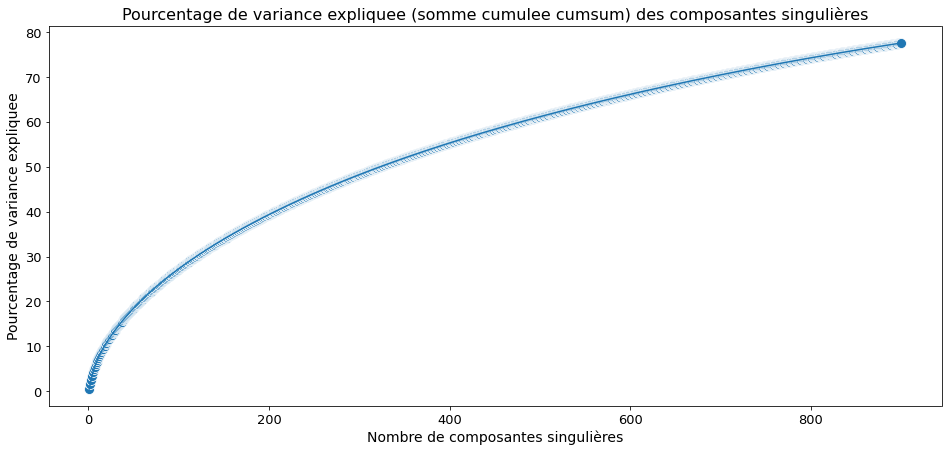

In [98]:
# Pourcentage de variance expliquee (somme cumulee cumsum) des composantes singulières
x = np.arange(len(svd.components_)) + 1
sb.lineplot(x, np.cumsum(svd.explained_variance_ratio_) * 100)
sb.scatterplot(x, np.cumsum(svd.explained_variance_ratio_) * 100, s=100)
plt.xlabel("Nombre de composantes singulières", size=14)
plt.ylabel("Pourcentage de variance expliquee", size=14)
plt.title("Pourcentage de variance expliquee (somme cumulee cumsum) des composantes singulières", size=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.xticks(np.arange(min(x), max(x)+1, 2.0))
plt.rcParams["figure.figsize"] = (16, 7)

In [30]:
# Performance du modele en fonction du nombre de dimensions gardees avec svd
num_iter = 5
scoring = ['f1_macro', 'recall']
min_dim = 2
max_dim = 2000
# max_dim = 900
step_dim = -100
list_num_dim = list(range(max_dim, min_dim, step_dim))
scores_f1 = []
scores_recall = []
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

print("debut")
for n_components in list_num_dim:
    svd = TruncatedSVD(n_components, n_iter=7, random_state=42)
    X_train_tfidf_svd = svd.fit_transform(X_train_tfidf)
    print("n_components = {} ; explained_variance_ratio_ = {}".format(n_components, sum(svd.explained_variance_ratio_ * 100)))

    model = SGDClassifier()
    kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=num_iter, random_state=None)
    cv_results = cross_validate(model, X_train_tfidf_svd, y_train, cv=kfold, scoring=scoring)
    for k, scores in cv_results.items():
        cv_results[k] = round(np.mean(scores), 4)
    scores_f1.append(cv_results["test_f1_macro"])
    scores_recall.append(cv_results["test_recall"])

debut
n_components = 2000 ; explained_variance_ratio_ = 98.19463303212576
n_components = 1900 ; explained_variance_ratio_ = 97.2904607715731
n_components = 1800 ; explained_variance_ratio_ = 96.22347297468488
n_components = 1700 ; explained_variance_ratio_ = 94.98691090112597
n_components = 1600 ; explained_variance_ratio_ = 93.5765684587774
n_components = 1500 ; explained_variance_ratio_ = 91.98136244607974
n_components = 1400 ; explained_variance_ratio_ = 90.18719498899623
n_components = 1300 ; explained_variance_ratio_ = 88.17966038408008
n_components = 1200 ; explained_variance_ratio_ = 85.93602927889162
n_components = 1100 ; explained_variance_ratio_ = 83.43811757924234
n_components = 1000 ; explained_variance_ratio_ = 80.66163501284511
n_components = 900 ; explained_variance_ratio_ = 77.5630024735008
n_components = 800 ; explained_variance_ratio_ = 74.11590501997574
n_components = 700 ; explained_variance_ratio_ = 70.26194575888246
n_components = 600 ; explained_variance_ratio_ =

20

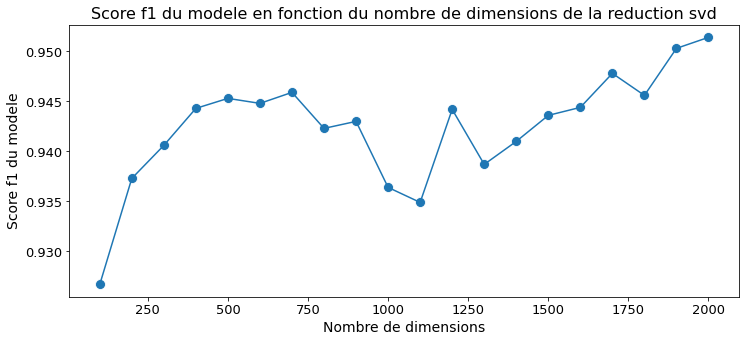

In [34]:
# Score f1 du modele en fonction du nombre de dimensions de la reduction svd
sb.lineplot(list_num_dim, scores_f1)
sb.scatterplot(list_num_dim, scores_f1, s=100)
plt.xlabel("Nombre de dimensions", size=14)
plt.ylabel("Score f1 du modele", size=14)
plt.title("Score f1 du modele en fonction du nombre de dimensions de la reduction svd", size=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.rcParams["figure.figsize"] = (12, 5)
len(scores_f1)

20

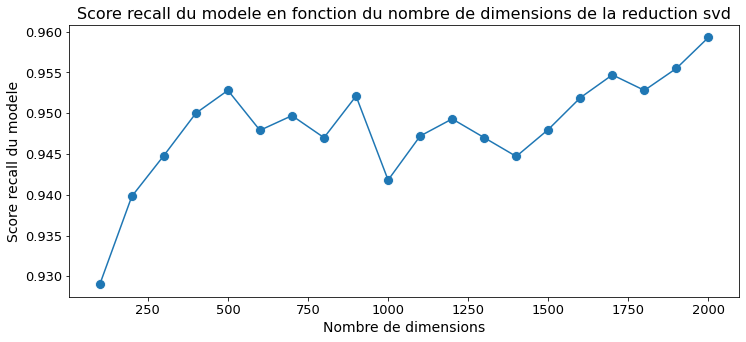

In [35]:
# Score scores_recall du modele en fonction du nombre de dimensions de la reduction svd
sb.lineplot(list_num_dim, scores_recall)
sb.scatterplot(list_num_dim, scores_recall, s=100)
plt.xlabel("Nombre de dimensions", size=14)
plt.ylabel("Score recall du modele", size=14)
plt.title("Score recall du modele en fonction du nombre de dimensions de la reduction svd", size=16)
plt.xticks(fontsize=13) 
plt.yticks(fontsize=13)
plt.rcParams["figure.figsize"] = (12, 5)
len(scores_recall)

In [44]:
# Methode 1 : automatique (cross validation de sklearn)
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning) #pour ignorer les warnings de type "deprecated"

# X = corpus["message_preprocessed"]
# # y = corpus["category"]
# y = corpus["category_bin"]
# indices = corpus["id"]
# X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.33, random_state=42)

# count_vectorizer = CountVectorizer()
# X_train_count = count_vectorizer.fit_transform(X_train)
# X_train_normalized = normalize(X_train_count, norm='l2', axis=1) #normalisation par ligne
# tfidf_vectorizer = TfidfVectorizer()
# X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# hashing_vectorizer = HashingVectorizer()
# X_train_hashing = hashing_vectorizer.fit_transform(X_train)
# X_train_observed_expected = vsm.observed_over_expected(X_train_count)
# X_train_pmi = vsm.pmi(X_train_count)

# X_test_count = count_vectorizer.transform(X_test)
# X_test_normalized = normalize(X_test_count, norm='l2', axis=1) #normalisation par ligne
# X_test_tfidf = tfidf_vectorizer.transform(X_test)
# X_test_hashing = hashing_vectorizer.transform(X_test)
# X_test_tfidf_svd = svd.transform(X_test_tfidf)
# X_test_observed_expected = vsm.observed_over_expected(X_test_count)
# X_test_pmi = vsm.pmi(X_test_count)

# transformations_names = ["count", "normalized", "tfidf", "hashing", "observed_expected", "pmi", "tfidf + lsa"]
# matrices_train = [X_train_count, X_train_normalized, X_train_tfidf, X_train_hashing, 
#                         X_train_observed_expected, X_train_pmi, X_train_tfidf_svd]
# matrices_test = [X_test_count, X_test_normalized, X_test_tfidf, X_test_hashing, 
#                     X_test_observed_expected, X_test_pmi, X_test_tfidf_svd]

test_size = 0.33
random_state = 42
n_components_svd = 2000
transformations_names, matrices_train, matrices_test = get_all_reweighted_matrices(X, y, indices, test_size, random_state, n_components_svd)
print(transformations_names)

scoring = ['f1_macro', 'recall']
num_iter = 5
for i_matrix in range(len(transformations_names)):
    model = SGDClassifier()
    matrix_train = matrices_train[i_matrix]
    matrix_name = transformations_names[i_matrix]

    kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=num_iter, random_state=None)
    cv_results = cross_validate(model, matrix_train, y_train, cv=kfold, scoring=scoring)
    for k, scores in cv_results.items():
        cv_results[k] = round(np.mean(scores), 4) #on fait la moyenne de chaque score (rappel, precision, etc.) pour les k experiences
    print((str(list(cv_results.items())[2:])+" ({0})").format(matrix_name)) #2: pour ignorer les info inutiles

c:\Users\eupho\anaconda3\lib\site-packages\scipy\sparse\base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


['count', 'normalized', 'tfidf', 'hashing', 'observed_expected', 'pmi', 'pmi + lsa', 'tfidf + lsa']
[('test_f1_macro', 0.9309), ('test_recall', 0.9423)] (count)
[('test_f1_macro', 0.9475), ('test_recall', 0.9567)] (normalized)
[('test_f1_macro', 0.9516), ('test_recall', 0.9572)] (tfidf)
[('test_f1_macro', 0.9438), ('test_recall', 0.9513)] (hashing)
[('test_f1_macro', 0.8137), ('test_recall', 0.8094)] (observed_expected)
[('test_f1_macro', 0.9258), ('test_recall', 0.9505)] (pmi)
[('test_f1_macro', 0.9239), ('test_recall', 0.9465)] (pmi + lsa)
[('test_f1_macro', 0.9497), ('test_recall', 0.9593)] (tfidf + lsa)


In [ ]:
# resultats sur philosophy_baptism
# [('test_f1_macro', 0.9356), ('test_recall', 0.9455)] (count)
# [('test_f1_macro', 0.945), ('test_recall', 0.9513)] (normalized)
# [('test_f1_macro', 0.9519), ('test_recall', 0.9575)] (tfidf)
# [('test_f1_macro', 0.9467), ('test_recall', 0.9526)] (hashing)
# [('test_f1_macro', 0.8107), ('test_recall', 0.8132)] (observed_expected)
# [('test_f1_macro', 0.9271), ('test_recall', 0.9381)] (pmi)
# [('test_f1_macro', 0.9195), ('test_recall', 0.9224)] (tfidf + lsa)

In [102]:
# Methode 2 : manuelle (split train test classique)
from sklearn.metrics import f1_score
from sklearn.linear_model import SGDClassifier

transformations_names = ["count", "normalized", "tfidf", "hashing", "observed_expected", "pmi"]
scores = [0, 0, 0, 0, 0, 0]
num_iter = 60

In [103]:
for iter in range(num_iter):
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.33, random_state=42)
    
    count_vectorizer = CountVectorizer()
    X_train_count = count_vectorizer.fit_transform(X_train)
    X_train_normalized = normalize(X_train_count, norm='l2', axis=1) #normalisation par ligne
    tfidf_vectorizer = TfidfVectorizer()
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    hashing_vectorizer = HashingVectorizer()
    X_train_hashing = hashing_vectorizer.fit_transform(X_train)
    X_train_observed_expected = vsm.observed_over_expected(X_train_count)
    X_train_pmi = vsm.pmi(X_train_count)

    X_test_count = count_vectorizer.transform(X_test)
    X_test_normalized = normalize(X_test_count, norm='l2', axis=1) #normalisation par ligne
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    X_test_hashing = hashing_vectorizer.transform(X_test)
    X_test_observed_expected = vsm.observed_over_expected(X_test_count)
    X_test_pmi = vsm.pmi(X_test_count)

    matrices_train = [X_train_count, X_train_normalized, X_train_tfidf, X_train_hashing, 
                        X_train_observed_expected, X_train_pmi]
    matrices_test = [X_test_count, X_test_normalized, X_test_tfidf, X_test_hashing, 
                        X_test_observed_expected, X_test_pmi]

    for i_matrix in range(len(transformations_names)):   
        model = SGDClassifier()
        matrix_train = matrices_train[i_matrix]
        matrix_test = matrices_test[i_matrix]
        model.fit(matrix_train, y_train)
        y_pred = model.predict(matrix_test)
        scores[i_matrix] += f1_score(y_test, y_pred, average='macro')

In [104]:
for i_matrix in range(len(transformations_names)):   
    print("test_f1_macro, {} ({})".format(scores[i_matrix] / num_iter, transformations_names[i_matrix]))

test_f1_macro, 0.9442974845526717 (count)
test_f1_macro, 0.9516293917765217 (normalized)
test_f1_macro, 0.957232907995305 (tfidf)
test_f1_macro, 0.9514486520843743 (hashing)
test_f1_macro, 0.8097246471012853 (observed_expected)
test_f1_macro, 0.9366296553617979 (pmi)
